This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [Chapter 14](https://www.deeplearningbook.org/contents/autoencoders.html) of the Deep Learning book, Lilian Weng's [From Autoencoder to Beta-VAE](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html), and the [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

Utils and imports (run and hide).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Lambda, Compose

device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")


def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().to(device) / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()
    
def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().to(device))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())
    
    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()

    
torch.manual_seed(1337) 
batch_size = 128 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

train_data = MNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)


test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=False)

## Discriminative vs. generative models

There are (generally) two approaches to statistical classification:
- *generative*, where we model the joint probability distribution $P(X,Y)$,
- *discriminative*, where we model the conditional probability of the target $Y$ given an observation $x$, $P(Y\vert X=x)$ (classifiers computed without using a probability model are also loosely referred to as "discriminative").

One can also think of generative models as learning the distribution of individual classes and discriminative models as learning (hard or soft) boundaries between classes.

Generative models allow you to generate data similar to training data, whereas discriminative models might be easier to learn.

See the [Wikipedia article](https://en.wikipedia.org/wiki/Generative_model) on generative models, the [CrossValidated question](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative), and the classic ML paper [On Discriminative vs. Generative Classifiers: A comparison of logistic regression and naive Bayes](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf) for more disambiguation.

Today we will work with the autoencoder model, first showing how to use it for semi-supervised learning, and later building a generative model.

## Vanilla autoencoder

An *autoencoder* is a neural network that is trained to copy it's input to its output. The network may be viewed as consisting of two parts: an *encoder* $g_\phi$, which takes in an input $\mathbf{x}$ and produces a *code* (also: *hidden representation*; *latent vector*) $\mathbf{z}=g_\phi(\mathbf{x})$ , and the *decoder* $f_\theta$, which produces a reconstruction $\mathbf{x'}=f_\theta(\mathbf{z})$.

![auto-encoder](figures/ae.png)
<center>Source: <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html">From Autoencoder to Beta-VAE</a>.</center>

If an autoencoder succeeds in simply learning to set $f_\theta(g_\phi(\mathbf{x}))=\mathbf{x}$ everywhere, then it is not especially useful. Instead, autoencoders are designed to be unable to learn to copy perfectly. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data.

The loss function for the vanilla autoencoder is the MSE between the input and output:
$$L_{AE} =\frac{1}{n}\sum_i \lVert\mathbf{x}_i-f_\theta(g_\phi(\mathbf{x}_i))\rVert_2^2.$$
The encoder and the decoder can be arbitrary neural networks, but usually the decoder is comprised of the same transformations as the encoder in reverse order.  

## Task 1 (0.25p)
Implement the encoder and the decoder for a vanilla autoencoder. 

The dimensions in the encoder are supposed to have the following number of neurons: `(784, 128, 128, 64, latent_dim)`. Analogously, for the decoder: `(latent_dim, 64, 128, 128, 784)`. (The input and output dimensionality corresponds to the number of pixels in MNIST.) `latent_dim` is supposed to be a parameter of the constructor.

Use no activation function after the encoder, a sigmoid after the decoder, and ReLU after the hidden layers.

In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(nn.Linear(784, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                     nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
                                     nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.BatchNorm1d(64), nn.ReLU(),
                                     nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                     nn.Linear(128, 784), nn.Sigmoid())
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0288  |  test loss: 0.0198


<Figure size 432x288 with 0 Axes>

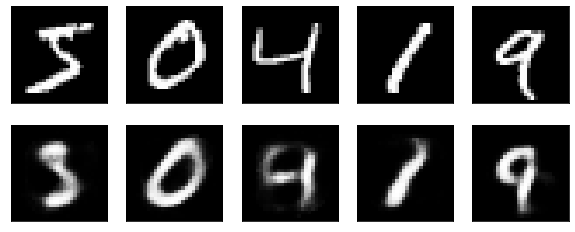

<Figure size 432x288 with 0 Axes>

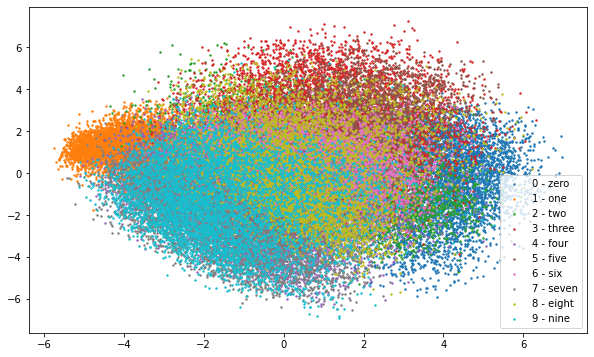

Epoch: 1  |  train loss: 0.0176  |  test loss: 0.0167
Epoch: 2  |  train loss: 0.0154  |  test loss: 0.0152
Epoch: 3  |  train loss: 0.0138  |  test loss: 0.0136
Epoch: 4  |  train loss: 0.0127  |  test loss: 0.0129
Epoch: 5  |  train loss: 0.0118  |  test loss: 0.0119
Epoch: 6  |  train loss: 0.0112  |  test loss: 0.0114
Epoch: 7  |  train loss: 0.0106  |  test loss: 0.0109
Epoch: 8  |  train loss: 0.0102  |  test loss: 0.0106
Epoch: 9  |  train loss: 0.0099  |  test loss: 0.0102
Epoch: 10  |  train loss: 0.0097  |  test loss: 0.0099


<Figure size 432x288 with 0 Axes>

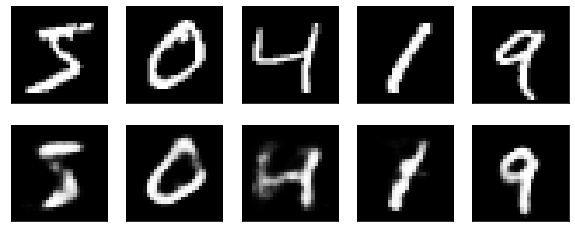

<Figure size 432x288 with 0 Axes>

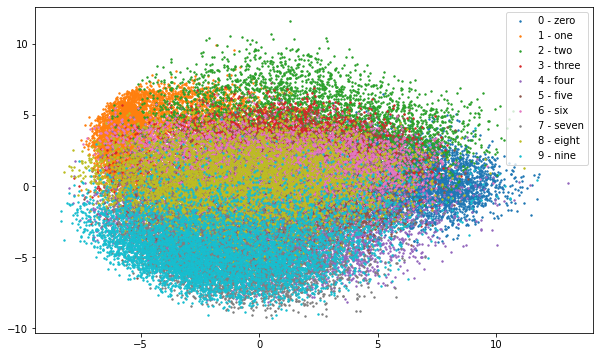

Epoch: 11  |  train loss: 0.0094  |  test loss: 0.0096
Epoch: 12  |  train loss: 0.0092  |  test loss: 0.0096
Epoch: 13  |  train loss: 0.0090  |  test loss: 0.0091
Epoch: 14  |  train loss: 0.0088  |  test loss: 0.0091
Epoch: 15  |  train loss: 0.0087  |  test loss: 0.0089
Epoch: 16  |  train loss: 0.0086  |  test loss: 0.0088
Epoch: 17  |  train loss: 0.0084  |  test loss: 0.0086
Epoch: 18  |  train loss: 0.0083  |  test loss: 0.0085
Epoch: 19  |  train loss: 0.0082  |  test loss: 0.0083
Epoch: 20  |  train loss: 0.0080  |  test loss: 0.0084


<Figure size 432x288 with 0 Axes>

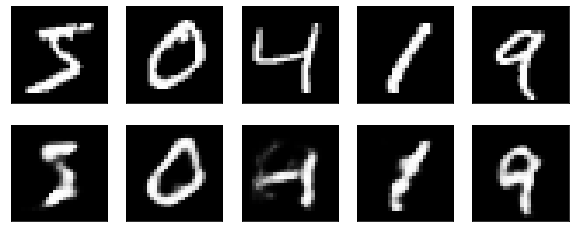

<Figure size 432x288 with 0 Axes>

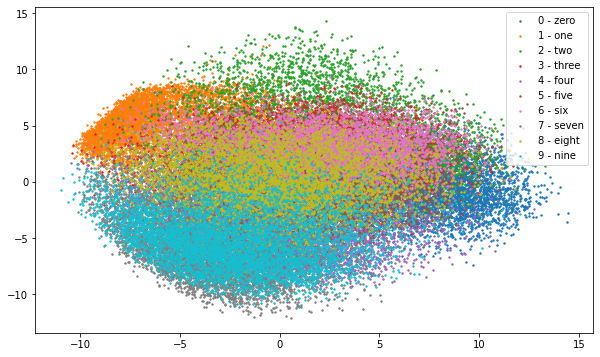

Epoch: 21  |  train loss: 0.0080  |  test loss: 0.0082
Epoch: 22  |  train loss: 0.0079  |  test loss: 0.0082
Epoch: 23  |  train loss: 0.0078  |  test loss: 0.0080
Epoch: 24  |  train loss: 0.0077  |  test loss: 0.0079
Epoch: 25  |  train loss: 0.0076  |  test loss: 0.0079
Epoch: 26  |  train loss: 0.0075  |  test loss: 0.0079
Epoch: 27  |  train loss: 0.0075  |  test loss: 0.0077
Epoch: 28  |  train loss: 0.0074  |  test loss: 0.0077
Epoch: 29  |  train loss: 0.0073  |  test loss: 0.0076
Epoch: 30  |  train loss: 0.0073  |  test loss: 0.0075


<Figure size 432x288 with 0 Axes>

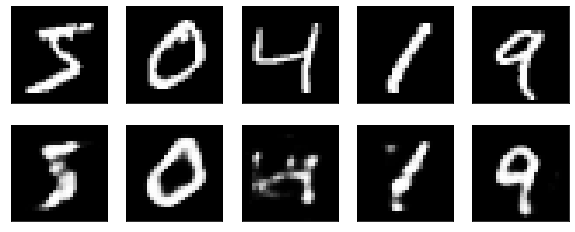

<Figure size 432x288 with 0 Axes>

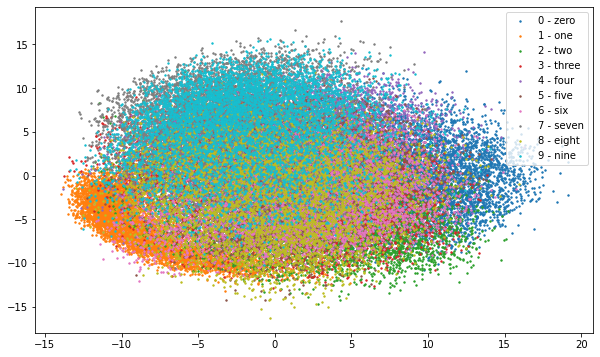

Epoch: 31  |  train loss: 0.0072  |  test loss: 0.0076
Epoch: 32  |  train loss: 0.0072  |  test loss: 0.0074
Epoch: 33  |  train loss: 0.0071  |  test loss: 0.0074
Epoch: 34  |  train loss: 0.0071  |  test loss: 0.0074
Epoch: 35  |  train loss: 0.0071  |  test loss: 0.0074
Epoch: 36  |  train loss: 0.0070  |  test loss: 0.0073
Epoch: 37  |  train loss: 0.0070  |  test loss: 0.0071
Epoch: 38  |  train loss: 0.0069  |  test loss: 0.0072
Epoch: 39  |  train loss: 0.0069  |  test loss: 0.0071
Epoch: 40  |  train loss: 0.0069  |  test loss: 0.0071


<Figure size 432x288 with 0 Axes>

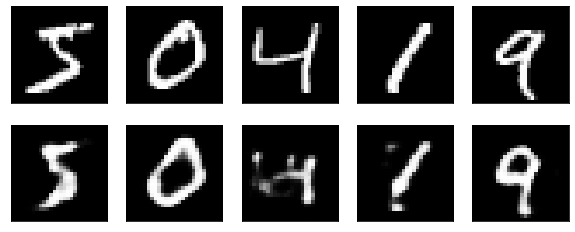

<Figure size 432x288 with 0 Axes>

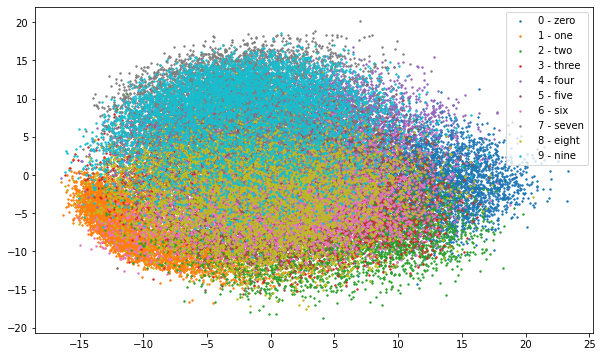

Epoch: 41  |  train loss: 0.0068  |  test loss: 0.0072
Epoch: 42  |  train loss: 0.0068  |  test loss: 0.0071
Epoch: 43  |  train loss: 0.0067  |  test loss: 0.0071
Epoch: 44  |  train loss: 0.0067  |  test loss: 0.0070
Epoch: 45  |  train loss: 0.0067  |  test loss: 0.0070
Epoch: 46  |  train loss: 0.0067  |  test loss: 0.0070
Epoch: 47  |  train loss: 0.0066  |  test loss: 0.0068
Epoch: 48  |  train loss: 0.0066  |  test loss: 0.0070
Epoch: 49  |  train loss: 0.0065  |  test loss: 0.0068
Epoch: 50  |  train loss: 0.0065  |  test loss: 0.0068


<Figure size 432x288 with 0 Axes>

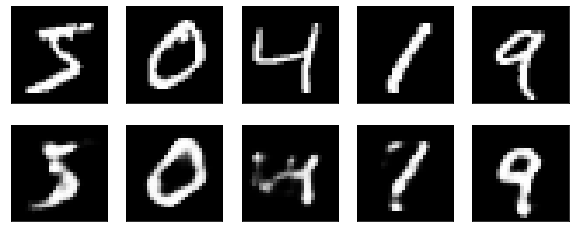

<Figure size 432x288 with 0 Axes>

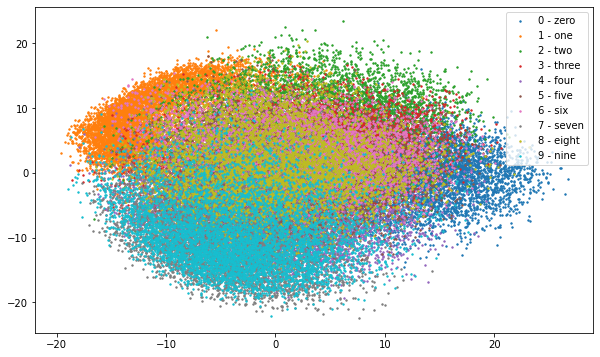

Epoch: 51  |  train loss: 0.0065  |  test loss: 0.0067
Epoch: 52  |  train loss: 0.0065  |  test loss: 0.0067
Epoch: 53  |  train loss: 0.0064  |  test loss: 0.0066
Epoch: 54  |  train loss: 0.0064  |  test loss: 0.0065
Epoch: 55  |  train loss: 0.0064  |  test loss: 0.0066
Epoch: 56  |  train loss: 0.0063  |  test loss: 0.0065
Epoch: 57  |  train loss: 0.0063  |  test loss: 0.0066
Epoch: 58  |  train loss: 0.0063  |  test loss: 0.0066
Epoch: 59  |  train loss: 0.0062  |  test loss: 0.0064
Epoch: 60  |  train loss: 0.0062  |  test loss: 0.0065


<Figure size 432x288 with 0 Axes>

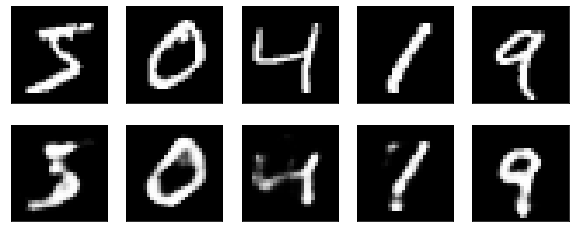

<Figure size 432x288 with 0 Axes>

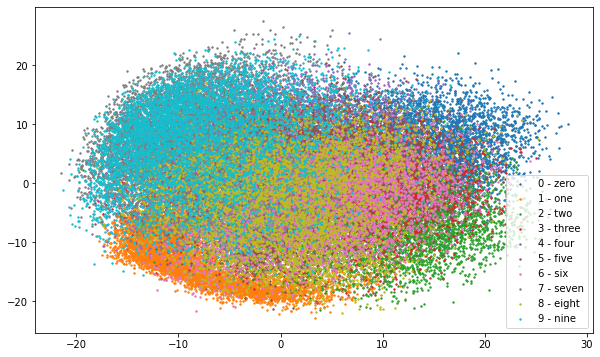

Epoch: 61  |  train loss: 0.0062  |  test loss: 0.0065
Epoch: 62  |  train loss: 0.0061  |  test loss: 0.0065
Epoch: 63  |  train loss: 0.0061  |  test loss: 0.0064
Epoch: 64  |  train loss: 0.0061  |  test loss: 0.0064
Epoch: 65  |  train loss: 0.0061  |  test loss: 0.0063
Epoch: 66  |  train loss: 0.0060  |  test loss: 0.0062
Epoch: 67  |  train loss: 0.0060  |  test loss: 0.0062
Epoch: 68  |  train loss: 0.0060  |  test loss: 0.0063
Epoch: 69  |  train loss: 0.0060  |  test loss: 0.0062
Epoch: 70  |  train loss: 0.0059  |  test loss: 0.0062


<Figure size 432x288 with 0 Axes>

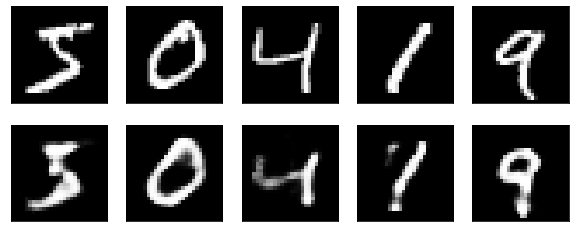

<Figure size 432x288 with 0 Axes>

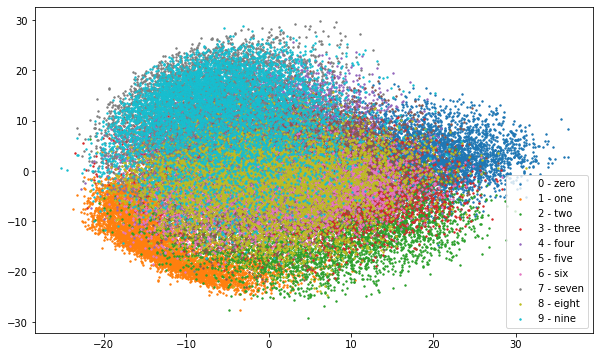

Epoch: 71  |  train loss: 0.0059  |  test loss: 0.0061
Epoch: 72  |  train loss: 0.0059  |  test loss: 0.0060
Epoch: 73  |  train loss: 0.0059  |  test loss: 0.0062
Epoch: 74  |  train loss: 0.0058  |  test loss: 0.0061
Epoch: 75  |  train loss: 0.0058  |  test loss: 0.0062
Epoch: 76  |  train loss: 0.0058  |  test loss: 0.0061
Epoch: 77  |  train loss: 0.0058  |  test loss: 0.0061
Epoch: 78  |  train loss: 0.0058  |  test loss: 0.0061
Epoch: 79  |  train loss: 0.0058  |  test loss: 0.0060
Epoch: 80  |  train loss: 0.0058  |  test loss: 0.0060


<Figure size 432x288 with 0 Axes>

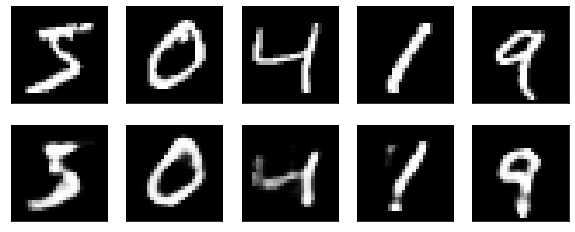

<Figure size 432x288 with 0 Axes>

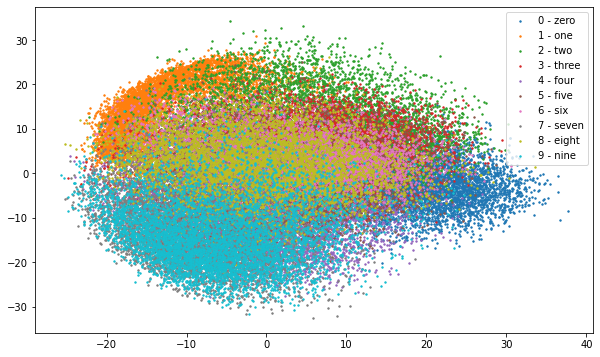

Epoch: 81  |  train loss: 0.0057  |  test loss: 0.0062
Epoch: 82  |  train loss: 0.0057  |  test loss: 0.0060
Epoch: 83  |  train loss: 0.0057  |  test loss: 0.0060
Epoch: 84  |  train loss: 0.0057  |  test loss: 0.0059
Epoch: 85  |  train loss: 0.0057  |  test loss: 0.0060
Epoch: 86  |  train loss: 0.0057  |  test loss: 0.0060
Epoch: 87  |  train loss: 0.0057  |  test loss: 0.0059
Epoch: 88  |  train loss: 0.0057  |  test loss: 0.0060
Epoch: 89  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 90  |  train loss: 0.0057  |  test loss: 0.0059


<Figure size 432x288 with 0 Axes>

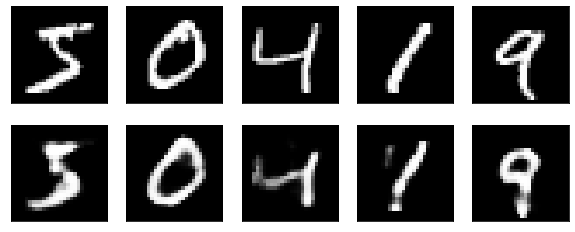

<Figure size 432x288 with 0 Axes>

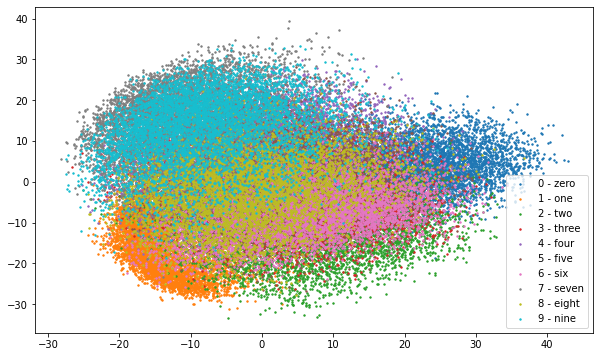

Epoch: 91  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 92  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 93  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 94  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 95  |  train loss: 0.0056  |  test loss: 0.0058
Epoch: 96  |  train loss: 0.0056  |  test loss: 0.0058
Epoch: 97  |  train loss: 0.0056  |  test loss: 0.0059
Epoch: 98  |  train loss: 0.0056  |  test loss: 0.0058
Epoch: 99  |  train loss: 0.0055  |  test loss: 0.0058
Epoch: 100  |  train loss: 0.0055  |  test loss: 0.0058


<Figure size 432x288 with 0 Axes>

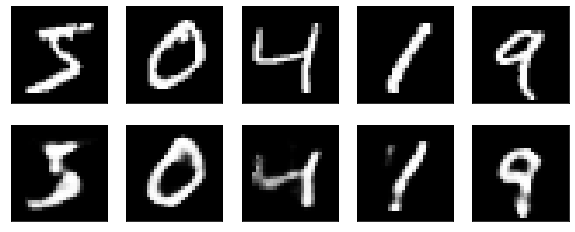

<Figure size 432x288 with 0 Axes>

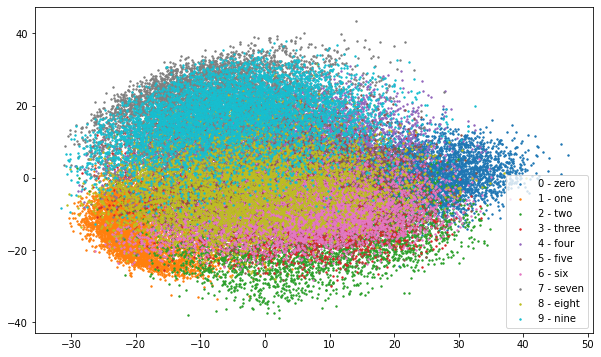

Epoch: 101  |  train loss: 0.0055  |  test loss: 0.0059
Epoch: 102  |  train loss: 0.0055  |  test loss: 0.0058
Epoch: 103  |  train loss: 0.0055  |  test loss: 0.0058
Epoch: 104  |  train loss: 0.0055  |  test loss: 0.0058
Epoch: 105  |  train loss: 0.0055  |  test loss: 0.0057
Epoch: 106  |  train loss: 0.0055  |  test loss: 0.0057
Epoch: 107  |  train loss: 0.0054  |  test loss: 0.0057
Epoch: 108  |  train loss: 0.0054  |  test loss: 0.0057
Epoch: 109  |  train loss: 0.0054  |  test loss: 0.0057
Epoch: 110  |  train loss: 0.0054  |  test loss: 0.0057


<Figure size 432x288 with 0 Axes>

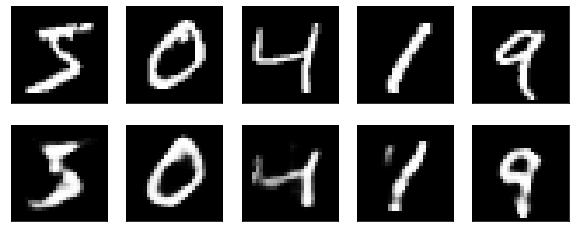

<Figure size 432x288 with 0 Axes>

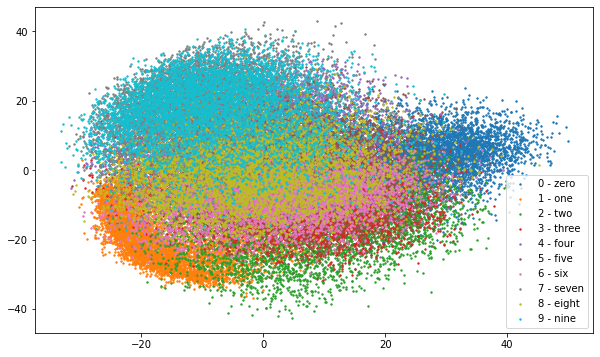

Epoch: 111  |  train loss: 0.0054  |  test loss: 0.0056
Epoch: 112  |  train loss: 0.0054  |  test loss: 0.0058
Epoch: 113  |  train loss: 0.0054  |  test loss: 0.0058
Epoch: 114  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 115  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 116  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 117  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 118  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 119  |  train loss: 0.0053  |  test loss: 0.0057
Epoch: 120  |  train loss: 0.0053  |  test loss: 0.0056


<Figure size 432x288 with 0 Axes>

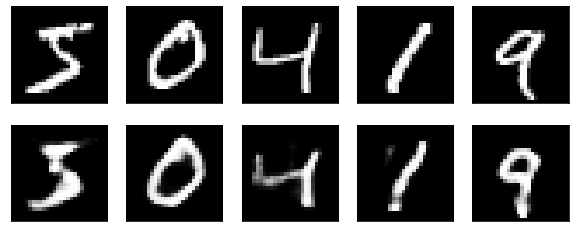

<Figure size 432x288 with 0 Axes>

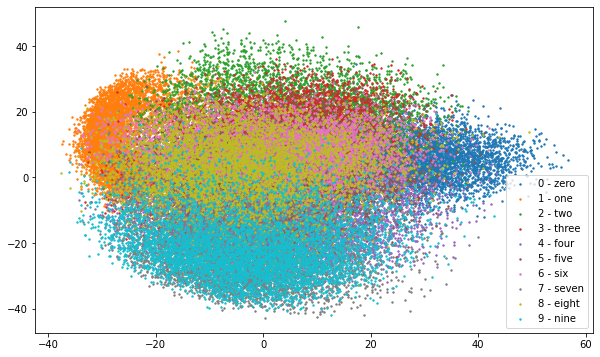

Epoch: 121  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 122  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 123  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 124  |  train loss: 0.0053  |  test loss: 0.0056
Epoch: 125  |  train loss: 0.0052  |  test loss: 0.0056
Epoch: 126  |  train loss: 0.0053  |  test loss: 0.0055
Epoch: 127  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 128  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 129  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 130  |  train loss: 0.0052  |  test loss: 0.0055


<Figure size 432x288 with 0 Axes>

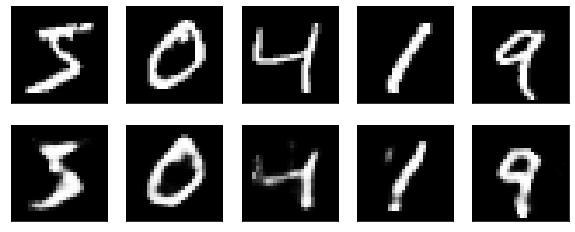

<Figure size 432x288 with 0 Axes>

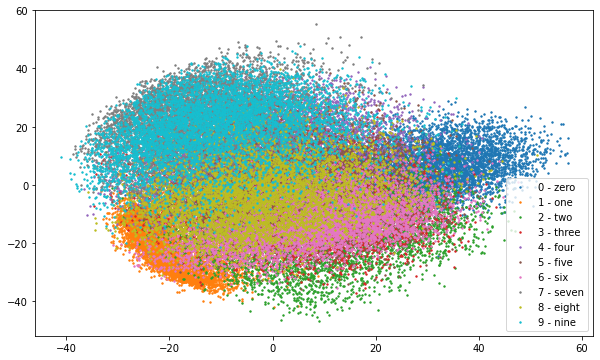

Epoch: 131  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 132  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 133  |  train loss: 0.0052  |  test loss: 0.0054
Epoch: 134  |  train loss: 0.0051  |  test loss: 0.0055
Epoch: 135  |  train loss: 0.0052  |  test loss: 0.0055
Epoch: 136  |  train loss: 0.0051  |  test loss: 0.0055
Epoch: 137  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 138  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 139  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 140  |  train loss: 0.0051  |  test loss: 0.0054


<Figure size 432x288 with 0 Axes>

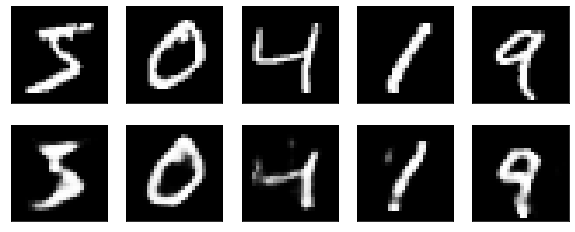

<Figure size 432x288 with 0 Axes>

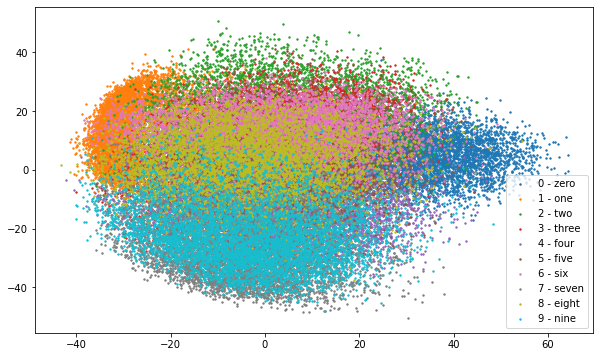

Epoch: 141  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 142  |  train loss: 0.0051  |  test loss: 0.0055
Epoch: 143  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 144  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 145  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 146  |  train loss: 0.0050  |  test loss: 0.0053
Epoch: 147  |  train loss: 0.0051  |  test loss: 0.0053
Epoch: 148  |  train loss: 0.0051  |  test loss: 0.0054
Epoch: 149  |  train loss: 0.0050  |  test loss: 0.0053
Epoch: 150  |  train loss: 0.0050  |  test loss: 0.0054


<Figure size 432x288 with 0 Axes>

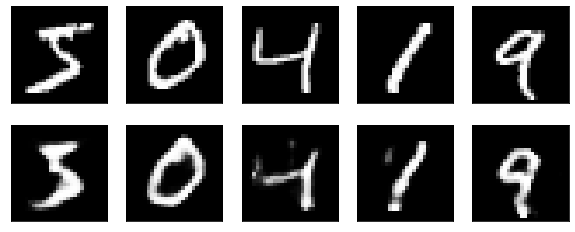

<Figure size 432x288 with 0 Axes>

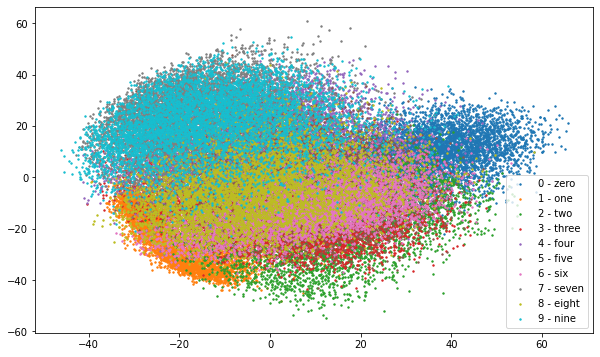

In [3]:
n_epochs = 151
lr = 5e-3        

autoencoder = AutoEncoder(latent_dim=32).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

for epoch in range(n_epochs):
    running_loss_train = 0  
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)       
        _, decoded = autoencoder(x) 
        loss = criterion(decoded, x)
        optimizer.zero_grad() 
        loss.backward()          
        optimizer.step()            
        running_loss_train += loss.item() * x.size(0)
        
    running_loss_test = 0 
    for step, (x, _) in enumerate(test_loader):
        x = x.to(device)       
        _, decoded = autoencoder(x) 
        loss = criterion(decoded, x)           
        running_loss_test += loss.item() * x.size(0)

    print(f'Epoch: {epoch}  |  train loss: {running_loss_train / len(train_loader.dataset):.4f}  |  test loss: {running_loss_test / len(test_loader.dataset):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Semi-supervised learning

In practice building a fully-labeled dataset can be very costly. If we want to train an image classifier, then gathering a large amount of data isn't a problem (we can scrape them from the internet, for example). Labelling them, however, is, and would require human resources. In some cases, labelling can be even more expensive -- in the segmentation task, where we want to assign a class to each pixel in the image, assigning the labels for one picture can take many hours.

Thus, we'd like to have methods which are able to utilize data for which we don't have labels. In the following task we'll build a simple semi-supervised model using an autoencoder.

## Task 2 (0.5p)

Assume that for the 60k examples from MNIST only 100 have the label. The 100 labeled examples are in the variable `labeled_data`.

1. Implement a classifier and train it on the 100 labeled examples. Report the accuracy on the test set. (The net should be relatively simple: max. 4 layers, max. 128 neurons in a layer).
2. Implement a classifier and train it on the 100 labeled examples with a similar architecture to the previous subtask, only that this time the input to the network will be the hidden representation $\mathbf{z}=g_\phi(\mathbf{x})$ created by the autoencoder in Task 1. Report the accuracy on the test set.
3. Compare the results of both models. Which model performed better? Do you have any hypotheses as to why?

In [4]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=False)

In [5]:
# implement and train the baseline model here

class BaselineModel(torch.nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        
        self.fn = torch.nn.Sequential(nn.Linear(784, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                      nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
                                      nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                                      nn.Linear(32, 10))

    def forward(self, x):
        return nn.functional.softmax(self.fn(x), dim=1)
    


In [7]:
n_epochs = 151
lr = 5e-3        

bl_model = BaselineModel().to(device)

optimizer_bl = torch.optim.Adam(bl_model.parameters(), lr=lr)
criterion_bl = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(n_epochs):
    running_loss_train = 0
    running_acc_train = 0
    for step, (x_true, y_true) in enumerate(labeled_loader):
        x_true, y_true = x_true.to(device), y_true.to(device)
        y_pred = bl_model(x_true)
        loss = criterion_bl(y_pred, y_true)
        optimizer_bl.zero_grad()
        loss.backward()          
        optimizer_bl.step()
        running_acc_train += (torch.argmax(y_pred.data, dim=1) == y_true).sum().item()
        running_loss_train += loss.item() * x_true.size(0)
    
    running_loss_test = 0
    running_acc_test = 0
    for step, (x_true, y_true) in enumerate(test_loader):
        x_true, y_true = x_true.to(device), y_true.to(device)        
        y_pred = bl_model(x_true) 
        loss = criterion_bl(y_pred, y_true)
        running_acc_test += (torch.argmax(y_pred.data, dim=1) == y_true).sum().item()
        running_loss_test += loss.item() * x_true.size(0)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}  |  train loss: {running_loss_train / len(labeled_loader.dataset):.4f}  |  test loss: {running_loss_test / len(test_loader.dataset):.4f}  |  train acc: {running_acc_train / len(labeled_loader.dataset):.4f}  |  test acc: {running_acc_test / len(test_loader.dataset):.4f}')

Epoch: 0  |  train loss: 2.2645  |  test loss: 2.1952  |  train acc: 0.2800  |  test acc: 0.4188
Epoch: 10  |  train loss: 1.6922  |  test loss: 1.9118  |  train acc: 0.8800  |  test acc: 0.5954
Epoch: 20  |  train loss: 1.5573  |  test loss: 1.8770  |  train acc: 0.9400  |  test acc: 0.6048
Epoch: 30  |  train loss: 1.5144  |  test loss: 1.8356  |  train acc: 0.9700  |  test acc: 0.6475
Epoch: 40  |  train loss: 1.5006  |  test loss: 1.8354  |  train acc: 0.9900  |  test acc: 0.6457
Epoch: 50  |  train loss: 1.4833  |  test loss: 1.8264  |  train acc: 1.0000  |  test acc: 0.6493
Epoch: 60  |  train loss: 1.4742  |  test loss: 1.8190  |  train acc: 0.9900  |  test acc: 0.6500
Epoch: 70  |  train loss: 1.5029  |  test loss: 1.8236  |  train acc: 0.9700  |  test acc: 0.6479
Epoch: 80  |  train loss: 1.4924  |  test loss: 1.8208  |  train acc: 0.9900  |  test acc: 0.6475
Epoch: 90  |  train loss: 1.4729  |  test loss: 1.8057  |  train acc: 1.0000  |  test acc: 0.6601
Epoch: 100  |  train 

In [8]:
# implement and train the model based on the representation produced by the autoencoder here

class SSModel(torch.nn.Module):
    def __init__(self, latent_dim):
        super(SSModel, self).__init__()
        
        self.fn = torch.nn.Sequential(nn.Linear(latent_dim, 128), nn.BatchNorm1d(128), nn.ReLU(),
                                      nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
                                      nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                                      nn.Linear(32, 10))

    def forward(self, x):
        return nn.functional.softmax(self.fn(x), dim=1)
    


In [9]:
n_epochs = 151
lr = 5e-3        

ss_model = SSModel(latent_dim=32).to(device)

optimizer_ss = torch.optim.Adam(ss_model.parameters(), lr=lr)
criterion_ss = torch.nn.CrossEntropyLoss().to(device)

for epoch in range(n_epochs):
    running_loss_train = 0
    running_acc_train = 0
    for step, (x_true, y_true) in enumerate(labeled_loader):
        x_true, y_true = x_true.to(device), y_true.to(device)
        encoded_x_true, _ = autoencoder(x_true)
        y_pred = ss_model(encoded_x_true)
        loss = criterion_ss(y_pred, y_true)
        optimizer_ss.zero_grad()
        loss.backward()          
        optimizer_ss.step()
        running_acc_train += (torch.argmax(y_pred.data, dim=1) == y_true).sum().item()
        running_loss_train += loss.item() * x_true.size(0)
    
    running_loss_test = 0
    running_acc_test = 0
    for step, (x_true, y_true) in enumerate(test_loader):
        x_true, y_true = x_true.to(device), y_true.to(device)        
        encoded_x_true, _ = autoencoder(x_true)
        y_pred = ss_model(encoded_x_true) 
        loss = criterion_ss(y_pred, y_true)
        running_acc_test += (torch.argmax(y_pred.data, dim=1) == y_true).sum().item()
        running_loss_test += loss.item() * x_true.size(0)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}  |  train loss: {running_loss_train / len(labeled_loader.dataset):.4f}  |  test loss: {running_loss_test / len(test_loader.dataset):.4f}  |  train acc: {running_acc_train / len(labeled_loader.dataset):.4f}  |  test acc: {running_acc_test / len(test_loader.dataset):.4f}')

Epoch: 0  |  train loss: 2.2705  |  test loss: 2.2008  |  train acc: 0.3000  |  test acc: 0.4259
Epoch: 10  |  train loss: 1.7169  |  test loss: 1.8953  |  train acc: 0.8300  |  test acc: 0.6290
Epoch: 20  |  train loss: 1.6202  |  test loss: 1.8592  |  train acc: 0.8600  |  test acc: 0.6200
Epoch: 30  |  train loss: 1.5828  |  test loss: 1.8540  |  train acc: 0.9100  |  test acc: 0.6426
Epoch: 40  |  train loss: 1.5167  |  test loss: 1.7984  |  train acc: 0.9700  |  test acc: 0.6922
Epoch: 50  |  train loss: 1.5140  |  test loss: 1.7967  |  train acc: 0.9600  |  test acc: 0.6818
Epoch: 60  |  train loss: 1.4998  |  test loss: 1.7840  |  train acc: 0.9800  |  test acc: 0.6925
Epoch: 70  |  train loss: 1.4938  |  test loss: 1.7860  |  train acc: 0.9800  |  test acc: 0.6877
Epoch: 80  |  train loss: 1.4767  |  test loss: 1.7893  |  train acc: 0.9900  |  test acc: 0.6822
Epoch: 90  |  train loss: 1.5017  |  test loss: 1.7896  |  train acc: 0.9700  |  test acc: 0.6815
Epoch: 100  |  train 

The model using the encoder, the vanilla autoencoder, learns slightly faster. The reason may be that the autoencoder, based on the reconstruction task, learns to abstract from images the essential aspects of classes common to all images in the dataset. This abstraction remains in use at the encoder output.

## Generative models

Neural-net based generative models allow us to [generate new faces](https://thispersondoesnotexist.com/) or [generate text](https://transformer.huggingface.co/doc/gpt2-large). The next task will involve creating a generative autoencoder and training it on the FashionMNIST dataset. 

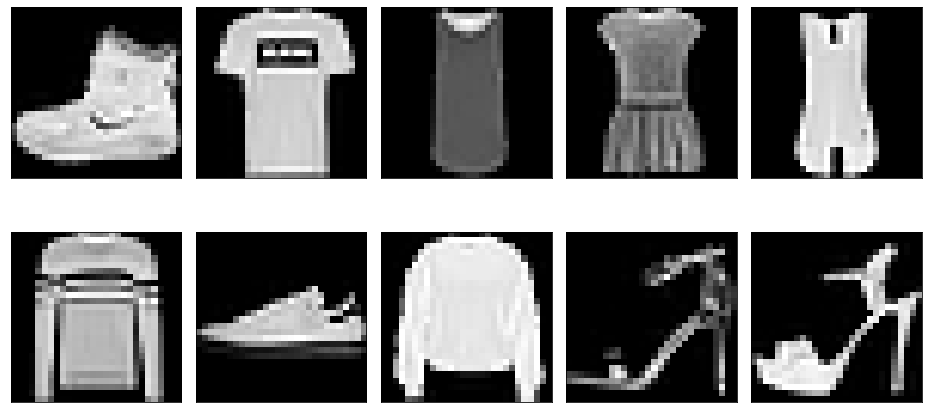

In [10]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                          train=True, 
                          transform=transforms,
                          download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = FashionMNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

fig, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())
fig.tight_layout()
plt.show()

## Wasserstein Autoencoder
The Wasserstein Autoencoder is identical in architecture to the vanilla one, with the additional constraint that the codes in the latent space are to form a normal distribution. Thanks to this we'll be able to generate new examples by sampling noise from the normal distribution and sending it through the decoder.

The loss function is comprised of two parts; the reconstruction loss and a distance between probability distributions:
$$L_{WAE-MMD} =\frac{1}{n}\sum_i \lVert\mathbf{x}_i-f_\theta(g_\phi(\mathbf{x}_i))\rVert_2^2+C\cdot \text{MMD}(g_\phi(\mathbf{x}_i),(\mathbf{y}_j)),$$
where $\mathbf{y}_j$ are samples from the normal distribution $\mathcal{N}(0, I)$, and $C \in \mathbb{R}$ is hyperparameter which weights the different components of the cost function.

The formula for Maximum Mean Discrepancy is as follows:
$$\text{MMD}((\mathbf{y}_i),(\mathbf{z}_j))=\frac{1}{n^2}\sum_{i,i'}k(\mathbf{y}_i,\mathbf{y}_{i'})+\frac{1}{n^2}\sum_{j,j'}k(\mathbf{z}_j,\mathbf{z}_{j'})-\frac{2}{n^2}\sum_{i,j}k(\mathbf{y}_i,\mathbf{z}_j),$$
where $k$ is a kernel function.

MMD describes a distance between the hidden representation $\mathbf{z}=g_\phi(\mathbf{x})$, obtained by passing the training examples through the encoder, and samples $\mathbf{y}_j\sim\mathcal{N}(0, I)$. Minimizing this cost will make the distribution produced by the encoder be more like the normal distribution, which is what we want to achieve.

We will use the IMQ (inverse multi-quadratic) kernel:
$$k(\mathbf{y}, \mathbf{z})=\frac{\sigma}{\sigma+\lvert\mathbf{y} - \mathbf{z} \rvert^2},$$
where $\sigma$ is a hyperparameter you need to find.

## Task 3 (1p)
Implement the Wasserstein Autoencoder with the Maximum Mean Discrepancy loss component.

1. Implement the autoencoder architecture (encoder + decoder) as in Task 1. The architecture should take into account that FashionMNIST is more complicated than MNIST (e.g. use 50 dimensions for the latent space).
2. Implement a training loop for WAE, where we minimize the loss function $L_{WAE-MMD}$.
3. Find hypeparameters (learning rate, number of training epochs, $C$, $\sigma$, etc.), so that the reconstruction and generated samples look decent (use the `plot_samples` function below). (Start from $C=1$, $\sigma=2D$, where $D$ is the dimensionality of the latent space.)

Cf. [the paper](https://arxiv.org/abs/1711.01558) and [the official implementation](https://github.com/tolstikhin/wae).

In [11]:
def plot_samples(model):
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    generated = generated.cpu().detach().numpy()
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
        ax.set_xticks(())
        ax.set_yticks(())
    fig.tight_layout()
    fig.suptitle("Generated samples")
    plt.show()

In [12]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(nn.Linear(784, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
                                     nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(),
                                     nn.Linear(64, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 784), nn.Sigmoid())
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
        z = torch.randn_like(y).to(device)
        n = y.shape[0]
        part1 = (sigma / (((y.unsqueeze(1) - y.unsqueeze(0))**2).sum(axis=2) + sigma)).sum()
        part2 = (sigma / (((z.unsqueeze(1) - z.unsqueeze(0))**2).sum(axis=2) + sigma)).sum()
        part3 = (sigma / (((z.unsqueeze(1) - y.unsqueeze(0))**2).sum(axis=2) + sigma)).sum()
        return (part1 + part2 - 2 * part3) / n**2

Epoch: 0  |  train loss: 0.0375  |  test loss: 0.0251


<Figure size 432x288 with 0 Axes>

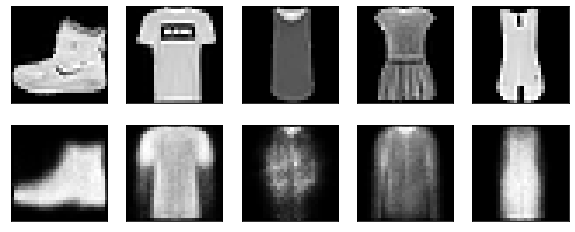

<Figure size 432x288 with 0 Axes>

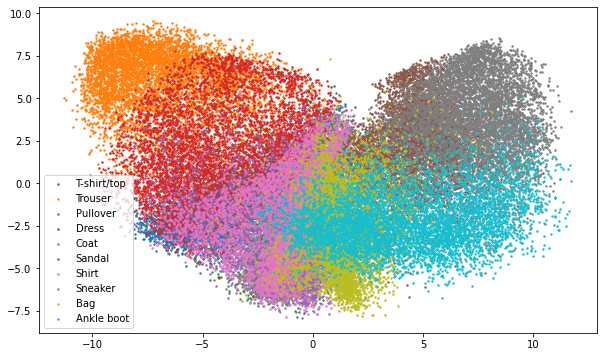

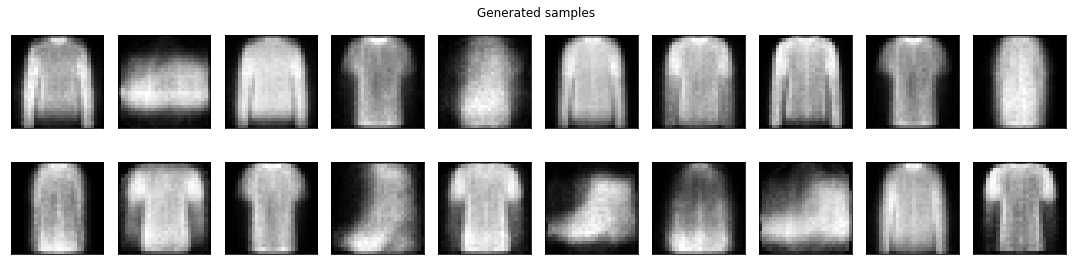

Epoch: 1  |  train loss: 0.0231  |  test loss: 0.0224
Epoch: 2  |  train loss: 0.0207  |  test loss: 0.0199
Epoch: 3  |  train loss: 0.0195  |  test loss: 0.0194
Epoch: 4  |  train loss: 0.0183  |  test loss: 0.0181
Epoch: 5  |  train loss: 0.0173  |  test loss: 0.0171
Epoch: 6  |  train loss: 0.0169  |  test loss: 0.0169
Epoch: 7  |  train loss: 0.0162  |  test loss: 0.0169
Epoch: 8  |  train loss: 0.0158  |  test loss: 0.0158
Epoch: 9  |  train loss: 0.0155  |  test loss: 0.0164
Epoch: 10  |  train loss: 0.0152  |  test loss: 0.0155


<Figure size 432x288 with 0 Axes>

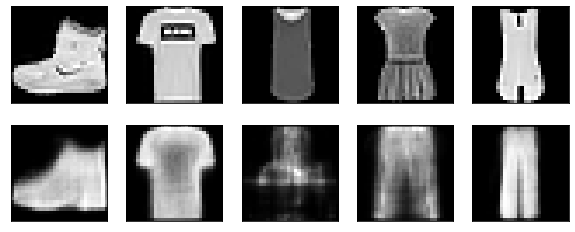

<Figure size 432x288 with 0 Axes>

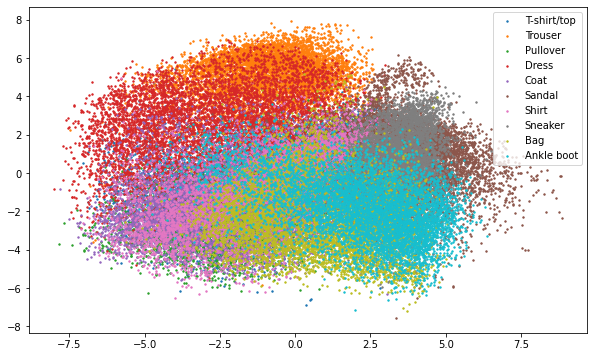

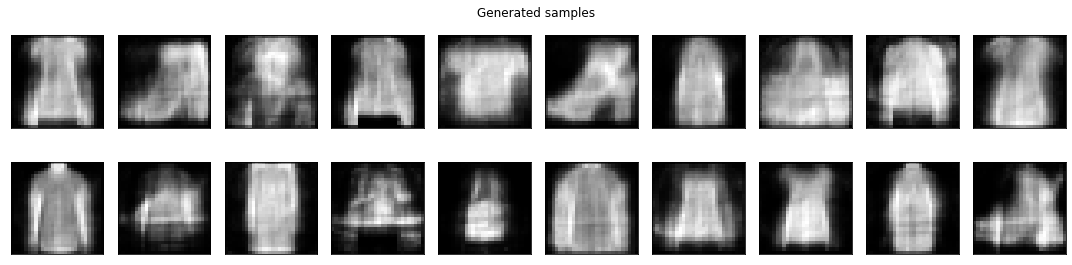

Epoch: 11  |  train loss: 0.0148  |  test loss: 0.0155
Epoch: 12  |  train loss: 0.0146  |  test loss: 0.0152
Epoch: 13  |  train loss: 0.0145  |  test loss: 0.0150
Epoch: 14  |  train loss: 0.0144  |  test loss: 0.0147
Epoch: 15  |  train loss: 0.0142  |  test loss: 0.0146
Epoch: 16  |  train loss: 0.0139  |  test loss: 0.0141
Epoch: 17  |  train loss: 0.0137  |  test loss: 0.0141
Epoch: 18  |  train loss: 0.0136  |  test loss: 0.0141
Epoch: 19  |  train loss: 0.0135  |  test loss: 0.0138
Epoch: 20  |  train loss: 0.0134  |  test loss: 0.0138


<Figure size 432x288 with 0 Axes>

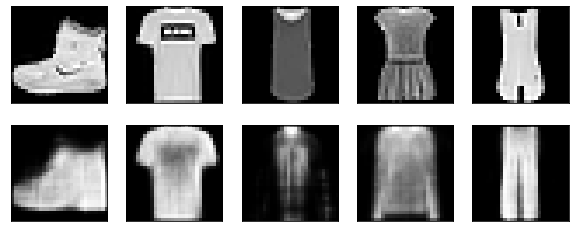

<Figure size 432x288 with 0 Axes>

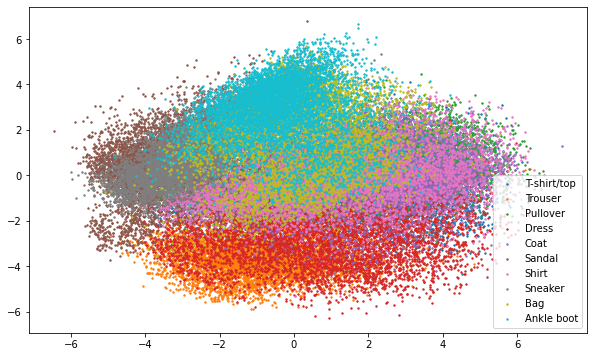

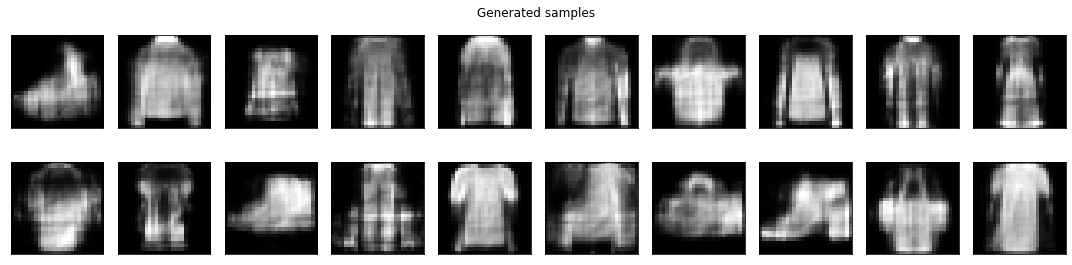

Epoch: 21  |  train loss: 0.0132  |  test loss: 0.0137
Epoch: 22  |  train loss: 0.0131  |  test loss: 0.0135
Epoch: 23  |  train loss: 0.0132  |  test loss: 0.0135
Epoch: 24  |  train loss: 0.0129  |  test loss: 0.0136
Epoch: 25  |  train loss: 0.0129  |  test loss: 0.0132
Epoch: 26  |  train loss: 0.0127  |  test loss: 0.0134
Epoch: 27  |  train loss: 0.0126  |  test loss: 0.0131
Epoch: 28  |  train loss: 0.0127  |  test loss: 0.0132
Epoch: 29  |  train loss: 0.0125  |  test loss: 0.0134
Epoch: 30  |  train loss: 0.0124  |  test loss: 0.0133


<Figure size 432x288 with 0 Axes>

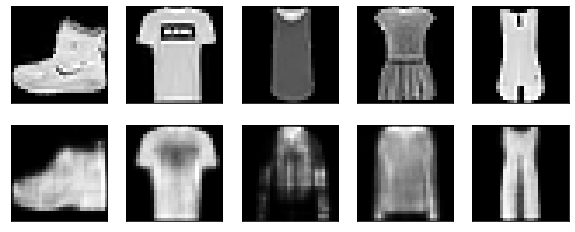

<Figure size 432x288 with 0 Axes>

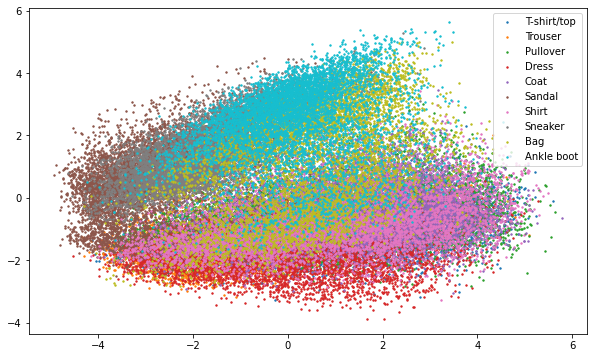

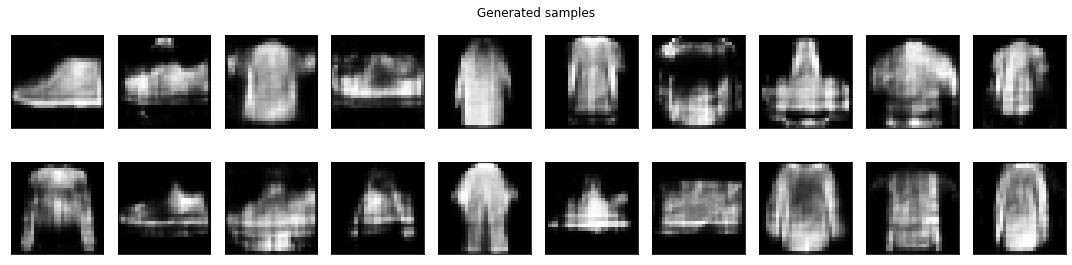

Epoch: 31  |  train loss: 0.0123  |  test loss: 0.0128
Epoch: 32  |  train loss: 0.0123  |  test loss: 0.0130
Epoch: 33  |  train loss: 0.0122  |  test loss: 0.0126
Epoch: 34  |  train loss: 0.0122  |  test loss: 0.0128
Epoch: 35  |  train loss: 0.0122  |  test loss: 0.0129
Epoch: 36  |  train loss: 0.0120  |  test loss: 0.0124
Epoch: 37  |  train loss: 0.0121  |  test loss: 0.0125
Epoch: 38  |  train loss: 0.0120  |  test loss: 0.0133
Epoch: 39  |  train loss: 0.0120  |  test loss: 0.0123
Epoch: 40  |  train loss: 0.0118  |  test loss: 0.0124


<Figure size 432x288 with 0 Axes>

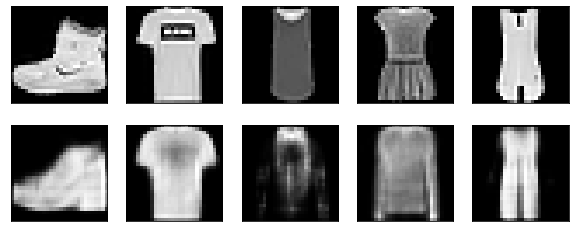

<Figure size 432x288 with 0 Axes>

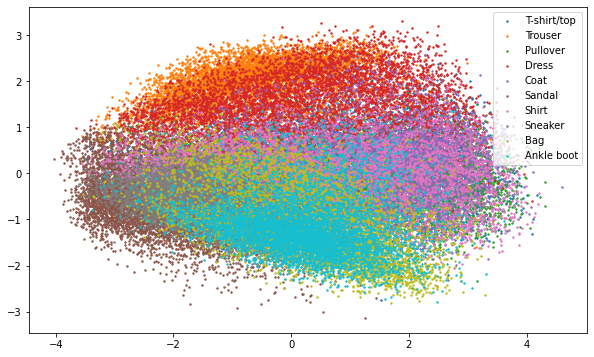

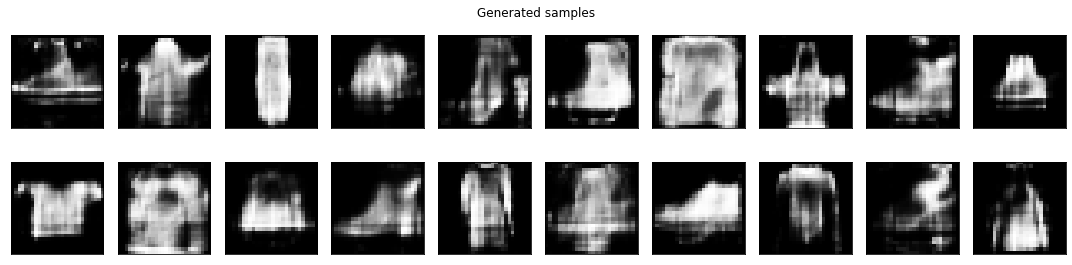

Epoch: 41  |  train loss: 0.0118  |  test loss: 0.0125
Epoch: 42  |  train loss: 0.0118  |  test loss: 0.0124
Epoch: 43  |  train loss: 0.0116  |  test loss: 0.0122
Epoch: 44  |  train loss: 0.0117  |  test loss: 0.0123
Epoch: 45  |  train loss: 0.0116  |  test loss: 0.0122
Epoch: 46  |  train loss: 0.0116  |  test loss: 0.0122
Epoch: 47  |  train loss: 0.0116  |  test loss: 0.0125
Epoch: 48  |  train loss: 0.0115  |  test loss: 0.0120
Epoch: 49  |  train loss: 0.0115  |  test loss: 0.0125
Epoch: 50  |  train loss: 0.0115  |  test loss: 0.0126


<Figure size 432x288 with 0 Axes>

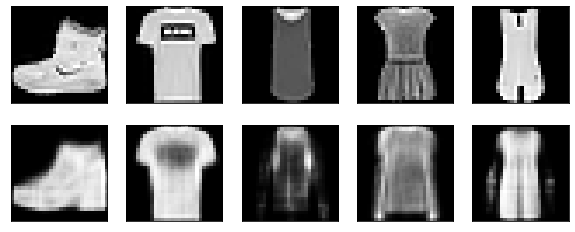

<Figure size 432x288 with 0 Axes>

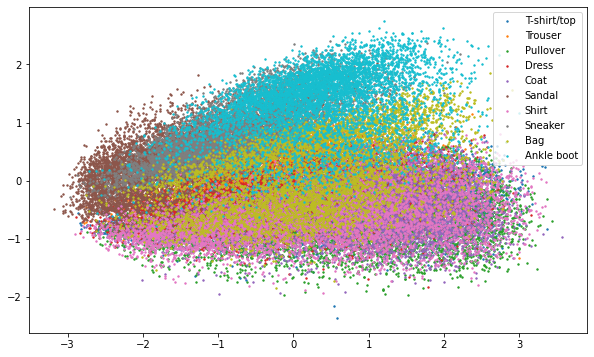

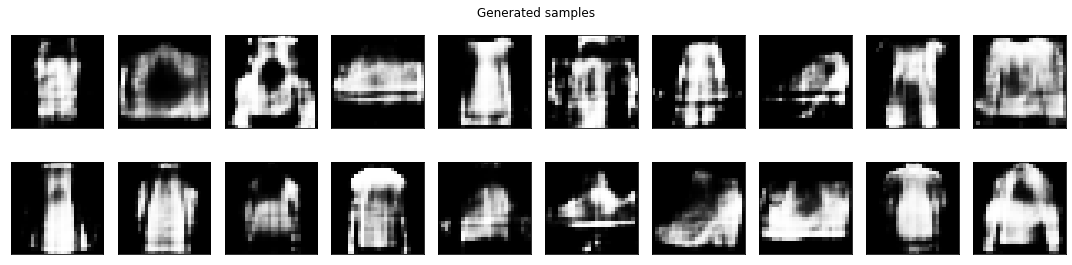

Epoch: 51  |  train loss: 0.0114  |  test loss: 0.0118
Epoch: 52  |  train loss: 0.0113  |  test loss: 0.0117


KeyboardInterrupt: 

In [13]:
n_epochs = 101
lr = 5e-3
latent_dim = 101

wae = WAEMMD(latent_dim).to(device)

optimizer_wae = torch.optim.Adam(wae.parameters(), lr=lr)
criterion_1 = torch.nn.MSELoss().to(device)

sigma = 10 * latent_dim
C = 0.005

for epoch in range(n_epochs):
    epoch_losses_train = []
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)
        encoded, decoded = wae(x)
        rec_loss = criterion_1(decoded, x)
        latent_loss = wae.mmd_loss(encoded, sigma)
        loss = rec_loss + C * latent_loss
        optimizer_wae.zero_grad()
        loss.backward()
        optimizer_wae.step()

        epoch_losses_train += [loss.item()]
        
    epoch_losses_test = []  
    for step, (x, _) in enumerate(test_loader):
        x = x.to(device)       
        encoded, decoded = wae(x)
        rec_loss = criterion_1(decoded, x)
        latent_loss = wae.mmd_loss(encoded, sigma)
        loss = rec_loss + C * latent_loss           
        epoch_losses_test.append(loss.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses_train):.4f}  |  test loss: {np.mean(epoch_losses_test):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)